In [1]:
from data_fns import load_fashion_mnist
from estimator import RFClassifier, classical_weights, V1_inspired_weights, relu, parallelized_clf
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import pickle

In [2]:
import dask
from dask.distributed import Client
client = Client(threads_per_worker=5, n_workers=5)
client

/home/bpandey/anaconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:34893 Dashboard: http://127.0.0.1:34831/status,Cluster Workers: 5 Cores: 25 Memory: 135.06 GB


In [3]:
# load data
X_train, y_train, X_test, y_test = load_fashion_mnist('data/fashion_mnist')

In [4]:
n_features = sorted(set(np.logspace(0, 4, 100).astype('int')))

# weight params
t, l = 5, 3
kwargs = {'t': t, 'l': l}
weights_V1 = {'weight_fun': V1_inspired_weights, 'kwargs': kwargs}
weights_classical = {'weight_fun': classical_weights}

# params for classification
sgd = SGDClassifier(loss="squared_hinge", alpha=1, max_iter=200, tol=1e-4, shuffle=True, n_jobs=5,
                    learning_rate="optimal", early_stopping=True, validation_fraction=0.1, n_iter_no_change=20)
b = np.mean(la.norm(X_train)/ np.sqrt(X_train.shape[0]))

In [ ]:
%%time
results = {}
m = np.zeros_like(n_features, dtype='float')
results['classical'] = {'avg_test_err': m.copy(), 'std_test_err': m.copy(), 'clf': m.astype('object').copy()}
results['V1'] = {'avg_test_err': m.copy(), 'std_test_err': m.copy(), 'clf':  m.astype('object').copy()}
for i, n in enumerate(n_features):

    # classical random features
    params_classical = {'width': n, **weights_classical, 'bias': b, 'nonlinearity': relu, 'clf': sgd}
    _, _, results['classical']['avg_test_err'][i], results['classical']['std_test_err'][i], results['classical']['clf'][i] = parallelized_clf(RFClassifier, 
                                                                                                    params_classical, 
                                                                                                    X_train, y_train, 
                                                                                                    X_test, y_test, 
                                                                                                    n_iters=5, return_clf=True)
    
    # haltere inspired
    params_V1 = {'width': n, **weights_V1, 'bias': b, 'nonlinearity': relu, 'clf': sgd} 
    _, _, results['V1']['avg_test_err'][i], results['V1']['std_test_err'][i], results['V1']['clf'][i] = parallelized_clf(RFClassifier, 
                                                                                                params_V1, 
                                                                                                X_train, y_train, 
                                                                                                X_test, y_test, 
                                                                                                n_iters=5, return_clf=True)

    print('Iter: %d/%d' % (i, len(n_features)))
    
with open('results/fashion_mnist_clf/fashion_mnist_clf_t=%0.2f_l=%0.2f.pickle' % (t, l), 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

Iter: 0/84
Iter: 1/84
Iter: 2/84
Iter: 3/84
Iter: 4/84
Iter: 5/84
Iter: 6/84
Iter: 7/84


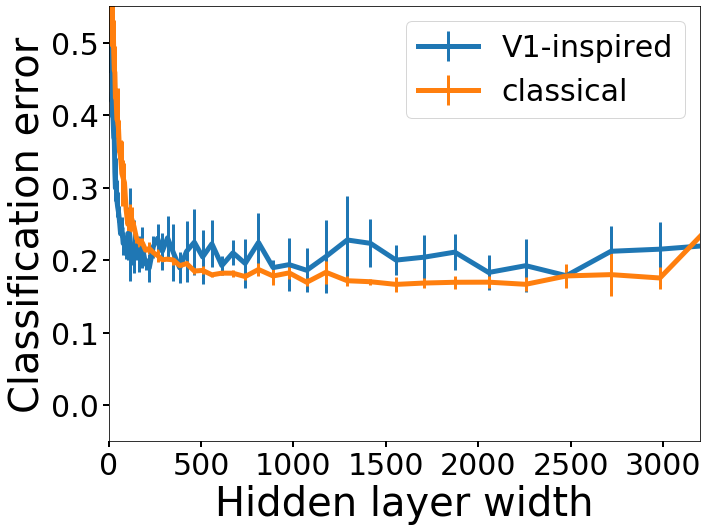

In [25]:
fig = plt.figure(figsize=(10.6, 8))
ax = fig.add_subplot(111)
ax.errorbar(n_features, results['V1']['avg_test_err'], yerr=results['V1']['std_test_err'], fmt='-', 
            label='V1-inspired',  markersize=4, lw=5, elinewidth=3)
ax.errorbar(n_features, results['classical']['avg_test_err'], yerr=results['classical']['std_test_err'], 
            fmt='-', label='classical', markersize=4, lw=5, elinewidth=3)
plt.xlabel('Hidden layer width', fontsize=40)
plt.ylabel('Classification error', fontsize=40)
plt.xticks(np.arange(0, 1020, 200))
plt.xlim([0, 3200])
plt.yticks(np.arange(0, 0.8, 0.1))
plt.ylim([-0.05, 0.55])
plt.xticks(np.arange(0, 3200, 500))
ax.tick_params(axis = 'both', which = 'major', labelsize = 30, width=2, length=6)

plt.legend(loc = 'upper right', fontsize=30)
plt.savefig('results/fashion_mnist_clf/fashion_mnist_clf_t=%0.2f_l=%0.2f.pdf' % (t, l))

In [10]:
list(zip(n_features, results['V1']['avg_test_err']))

[(1, 0.8584400000000001),
 (2, 0.80306),
 (3, 0.74116),
 (4, 0.69194),
 (5, 0.68736),
 (6, 0.61378),
 (7, 0.5135000000000001),
 (8, 0.57136),
 (9, 0.55898),
 (10, 0.52244),
 (11, 0.5251999999999999),
 (12, 0.5031200000000001),
 (13, 0.48566000000000004),
 (14, 0.47912),
 (16, 0.46044),
 (17, 0.49781999999999993),
 (19, 0.41853999999999997),
 (21, 0.43170000000000003),
 (23, 0.40164),
 (25, 0.39078),
 (28, 0.36888),
 (31, 0.36719999999999997),
 (34, 0.32192),
 (37, 0.2995),
 (41, 0.30893999999999994),
 (45, 0.28266),
 (49, 0.27368),
 (54, 0.26559999999999995),
 (59, 0.25432000000000005),
 (65, 0.2363),
 (72, 0.24462),
 (79, 0.2231),
 (86, 0.22148000000000004),
 (95, 0.20903999999999998),
 (104, 0.23676),
 (114, 0.23593999999999998),
 (126, 0.2045),
 (138, 0.21902),
 (151, 0.21467999999999998),
 (166, 0.20818000000000003),
 (183, 0.21742),
 (200, 0.19507999999999998),
 (220, 0.18908000000000003),
 (242, 0.2186),
 (265, 0.23006),
 (291, 0.2122),
 (319, 0.23078000000000004),
 (351, 0.20998

In [15]:
with open('results/fashion_mnist_clf/fashion_mnist_clf_t=%0.2f_l=%0.2f.pickle' % (t, l), 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

KeyboardInterrupt: 